In [1]:
import tensorflow as tf

# Check and show available devices
devices = tf.config.list_physical_devices()
print("✅ TensorFlow:", tf.__version__)
print("🔍 Available devices:", devices)

# Use CPU-only strategy
strategy = tf.distribute.get_strategy()
print("⚙️ Running with:", strategy.num_replicas_in_sync, "replica(s) on CPU")


✅ TensorFlow: 2.19.0
🔍 Available devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
⚙️ Running with: 1 replica(s) on CPU


In [2]:
# STEP 1 — Environment Setup (compatible with Python 3.12)
import sys
print("Python", sys.version)

# ✅ Install latest compatible TensorFlow + dependencies
!pip install -q tensorflow==2.18.0
!pip install -q opencv-python imgaug


Python 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.5/615.5 MB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 57.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jaxlib 0.7.2 requires ml_dtypes>=0.5.0, but you have ml-dtypes 0.4.1 which is incompatible.
tensorstore 0.1.79 requires ml_dtypes>=0.5.0, but you have ml-dtypes 0.4.1 which is incompatible.
tensorflow-decision-forests 1.12.0 requires tensorflow==2.19.0, but you have tensorflow 2.18.0 which is incompatible.
tensorflow-text 2.19.0 requires tensorflow<2.20,>=2.19.0, but you have tensorflow 2.18.0 which is incompatible.
tf-keras 2.19.0 requires tensorflow<2.20,>=2.19, but you have tensorflow 2.18.0 which is incompatible.
jax 0.7.2 r

In [3]:
# STEP 2 — Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!apt -qq install unrar


unrar is already the newest version (1:6.1.5-1ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.


In [ ]:
!unrar x "/content/drive/MyDrive/colorectal/datasets/clinicdb.rar" /content/datasets/CVC



UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal


Extracting from /content/drive/MyDrive/colorectal/datasets/clinicdb.rar


Would you like to replace the existing file /content/datasets/CVC/CVC-ClinicDB/Ground Truth/1.tif
111048 bytes, modified on 2014-12-04 17:33
with a new one
111048 bytes, modified on 2014-12-04 17:33

[Y]es, [N]o, [A]ll, n[E]ver, [R]ename, [Q]uit Y

Extracting  /content/datasets/CVC/CVC-ClinicDB/Ground Truth/1.tif          0%  OK 

Would you like to replace the existing file /content/datasets/CVC/CVC-ClinicDB/Ground Truth/10.tif
111048 bytes, modified on 2014-12-04 17:33
with a new one
111048 bytes, modified on 2014-12-04 17:33

[Y]es, [N]o, [A]ll, n[E]ver, [R]ename, [Q]uit Y

Extracting  /content/datasets/CVC/CVC-ClinicDB/Ground Truth/10.tif         0%  OK 

Would you like to replace the existing file /content/datasets/CVC/CVC-ClinicDB/Ground Truth/100.tif
111048 bytes, modified on 2014-12-04 17:33
with a new one
111048 

In [ ]:
!ls /content/datasets/CVC/CVC-ClinicDB

'Ground Truth'	 Original   README.txt


In [ ]:
!ls /content/datasets/CVC/CVC-ClinicDB/Original | head


100.tif
101.tif
102.tif
103.tif
104.tif
105.tif
106.tif
107.tif
108.tif
109.tif


In [4]:
DATASET_DIR = "/content/drive/MyDrive/colorectal/datasets"

kvasir_path = f"/content/drive/MyDrive/colorectal/datasets/Kvasir-SEG/"

# UPDATED ClinicDB path (based on your extraction location)
clinicdb_path = "/content/datasets/CVC/CVC-ClinicDB/"

print("Kvasir path:", kvasir_path)
print("ClinicDB path:", clinicdb_path)


Kvasir path: /content/drive/MyDrive/colorectal/datasets/Kvasir-SEG/
ClinicDB path: /content/datasets/CVC/CVC-ClinicDB/


In [5]:
# STEP 4 — Detect images & masks from both datasets
import os
import glob

# Define directories (Kvasir stays the same)
kvasir_img_dir = "/content/drive/MyDrive/colorectal/datasets/Kvasir-SEG/images"
kvasir_mask_dir = "/content/drive/MyDrive/colorectal/datasets/Kvasir-SEG/masks"

# UPDATED CVC-ClinicDB paths (correct extraction location)
cvc_img_dir = "/content/drive/MyDrive/colorectal/datasets/CVC-ClinicDB/Original"
cvc_mask_dir = "/content/drive/MyDrive/colorectal/datasets/CVC-ClinicDB/Ground Truth"

# Function to collect files
def collect_files(img_dir, mask_dir):
    img_exts = ("*.jpg", "*.jpeg", "*.png", "*.tif", "*.bmp")
    imgs = []
    for ext in img_exts:
        imgs.extend(glob.glob(os.path.join(img_dir, ext)))
    masks = []
    for ext in img_exts:
        masks.extend(glob.glob(os.path.join(mask_dir, ext)))
    return sorted(imgs), sorted(masks)

# Load Kvasir and CVC datasets
kvasir_imgs, kvasir_masks = collect_files(kvasir_img_dir, kvasir_mask_dir)
cvc_imgs, cvc_masks = collect_files(cvc_img_dir, cvc_mask_dir)

# Combine
all_imgs = kvasir_imgs + cvc_imgs
all_masks = kvasir_masks + cvc_masks

# Print stats
print(f"Kvasir images: {len(kvasir_imgs)}, masks: {len(kvasir_masks)}")
print(f"CVC images: {len(cvc_imgs)}, masks: {len(cvc_masks)}")
print(f"Total combined: {len(all_imgs)} images | {len(all_masks)} masks")

# Show sample files
print("\nExample image files:", all_imgs[:3])
print("Example mask files:", all_masks[:3])


Kvasir images: 1000, masks: 1000
CVC images: 612, masks: 612
Total combined: 1612 images | 1612 masks

Example image files: ['/content/drive/MyDrive/colorectal/datasets/Kvasir-SEG/images/cju0qkwl35piu0993l0dewei2.jpg', '/content/drive/MyDrive/colorectal/datasets/Kvasir-SEG/images/cju0qoxqj9q6s0835b43399p4.jpg', '/content/drive/MyDrive/colorectal/datasets/Kvasir-SEG/images/cju0qx73cjw570799j4n5cjze.jpg']
Example mask files: ['/content/drive/MyDrive/colorectal/datasets/Kvasir-SEG/masks/cju0qkwl35piu0993l0dewei2.jpg', '/content/drive/MyDrive/colorectal/datasets/Kvasir-SEG/masks/cju0qoxqj9q6s0835b43399p4.jpg', '/content/drive/MyDrive/colorectal/datasets/Kvasir-SEG/masks/cju0qx73cjw570799j4n5cjze.jpg']


In [ ]:
!mkdir -p "/content/drive/MyDrive/colorectal/datasets/CVC-ClinicDB"
!cp -r /content/datasets/CVC/CVC-ClinicDB/* "/content/drive/MyDrive/colorectal/datasets/CVC-ClinicDB/"


In [ ]:
import os

# Path where your RAR file exists
BASE_DIR = "/content/drive/MyDrive/colorectal/datasets"

RAR_FILE = f"/content/drive/MyDrive/colorectal/datasets/clinicdb.rar"

# Create extraction folder inside the same directory
EXTRACT_DIR = f"{BASE_DIR}/CVC-ClinicDB"
os.makedirs(EXTRACT_DIR, exist_ok=True)

# Install unrar
!apt -qq install unrar

# Extract everything into the new folder
!unrar x "{RAR_FILE}" "{EXTRACT_DIR}/"


unrar is already the newest version (1:6.1.5-1ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.

UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal


Extracting from /content/drive/MyDrive/colorectal/datasets/clinicdb.rar

Creating    /content/drive/MyDrive/colorectal/datasets/CVC-ClinicDB/CVC-ClinicDB  OK
Creating    /content/drive/MyDrive/colorectal/datasets/CVC-ClinicDB/CVC-ClinicDB/Ground Truth  OK
Extracting  /content/drive/MyDrive/colorectal/datasets/CVC-ClinicDB/CVC-ClinicDB/Ground Truth/1.tif       0%  OK 
Extracting  /content/drive/MyDrive/colorectal/datasets/CVC-ClinicDB/CVC-ClinicDB/Ground Truth/10.tif       0%  OK 
Extracting  /content/drive/MyDrive/colorectal/datasets/CVC-ClinicDB/CVC-ClinicDB/Ground Truth/100.tif       0%  OK 
Extracting  /content/drive/MyDrive/colorectal/datasets/CVC-ClinicDB/CVC-ClinicDB/Ground Truth/101.tif       0%  OK 
Extracting  /content/drive/MyDrive/colorectal/dat

In [ ]:
!ls "/content/drive/MyDrive/colorectal/datasets/CVC-ClinicDB"


 CVC-ClinicDB  'Ground Truth'   Original   README.txt


In [6]:
import os
import shutil
import glob

# Source dataset directories
kvasir_img_dir = "/content/drive/MyDrive/colorectal/datasets/Kvasir-SEG/images"
kvasir_mask_dir = "/content/drive/MyDrive/colorectal/datasets/Kvasir-SEG/masks"

cvc_img_dir = "/content/drive/MyDrive/colorectal/datasets/CVC-ClinicDB/Original"
cvc_mask_dir = "/content/drive/MyDrive/colorectal/datasets/CVC-ClinicDB/Ground Truth"

# Destination merged directories
merged_root = "/content/drive/MyDrive/colorectal/combined"
merged_img_dir = os.path.join(merged_root, "images")
merged_mask_dir = os.path.join(merged_root, "masks")

# Create folders if not exist
os.makedirs(merged_img_dir, exist_ok=True)
os.makedirs(merged_mask_dir, exist_ok=True)

# Function to copy and rename files safely
def merge_dataset(img_dir, mask_dir, prefix):
    img_paths = sorted(glob.glob(os.path.join(img_dir, "*")))
    mask_paths = sorted(glob.glob(os.path.join(mask_dir, "*")))

    print(f"Merging {prefix}: {len(img_paths)} images, {len(mask_paths)} masks")

    for i, (img, mask) in enumerate(zip(img_paths, mask_paths)):
        new_img_name = f"{prefix}_img_{i:04d}.png"
        new_mask_name = f"{prefix}_mask_{i:04d}.png"

        shutil.copy(img, os.path.join(merged_img_dir, new_img_name))
        shutil.copy(mask, os.path.join(merged_mask_dir, new_mask_name))

    return len(img_paths)

# Merge both datasets
count_kvasir = merge_dataset(kvasir_img_dir, kvasir_mask_dir, "kvasir")
count_cvc = merge_dataset(cvc_img_dir, cvc_mask_dir, "cvc")

print("Merged completed.")
print(f"Total merged images: {count_kvasir + count_cvc}")


Merging kvasir: 1000 images, 1000 masks
Merging cvc: 612 images, 612 masks
Merged completed.
Total merged images: 1612


In [7]:
import os
import glob
from sklearn.model_selection import train_test_split

# Merged dataset paths (CONFIRMED)
merged_img_dir  = "/content/drive/MyDrive/colorectal/combined/images"
merged_mask_dir = "/content/drive/MyDrive/colorectal/combined/masks"

# Collect files
images = sorted(glob.glob(os.path.join(merged_img_dir, "*")))
masks  = sorted(glob.glob(os.path.join(merged_mask_dir, "*")))

print("Total images:", len(images))
print("Total masks :", len(masks))

assert len(images) == len(masks), "Image-mask count mismatch!"


Total images: 1612
Total masks : 1612


In [8]:
# First split: Train (70%) + Temp (30%)
train_imgs, temp_imgs, train_masks, temp_masks = train_test_split(
    images,
    masks,
    test_size=0.30,
    random_state=42
)

# Second split: Validation (15%) + Test (15%)
val_imgs, test_imgs, val_masks, test_masks = train_test_split(
    temp_imgs,
    temp_masks,
    test_size=0.50,
    random_state=42
)

print(f"Train: {len(train_imgs)}")
print(f"Val  : {len(val_imgs)}")
print(f"Test : {len(test_imgs)}")


Train: 1128
Val  : 242
Test : 242


In [9]:
for i in range(3):
    print(
        os.path.basename(train_imgs[i]),
        "<->",
        os.path.basename(train_masks[i])
    )


kvasir_img_0311.png <-> kvasir_mask_0311.png
kvasir_img_0516.png <-> kvasir_mask_0516.png
kvasir_img_0651.png <-> kvasir_mask_0651.png


In [10]:
import tensorflow as tf

IMG_HEIGHT = 256
IMG_WIDTH  = 256
IMG_CHANNELS = 3
BATCH_SIZE = 8


In [11]:
def load_image(img_path, mask_path):
    # Read image
    img = tf.io.read_file(img_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, (IMG_HEIGHT, IMG_WIDTH))
    img = tf.cast(img, tf.float32) / 255.0

    # Read mask
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.resize(
        mask, (IMG_HEIGHT, IMG_WIDTH),
        method=tf.image.ResizeMethod.NEAREST_NEIGHBOR
    )
    mask = tf.cast(mask > 0, tf.float32)

    return img, mask


In [12]:
def augment(img, mask):
    if tf.random.uniform(()) > 0.5:
        img  = tf.image.flip_left_right(img)
        mask = tf.image.flip_left_right(mask)

    if tf.random.uniform(()) > 0.5:
        img  = tf.image.flip_up_down(img)
        mask = tf.image.flip_up_down(mask)

    return img, mask


In [13]:
def build_dataset(imgs, masks, training=False):
    ds = tf.data.Dataset.from_tensor_slices((imgs, masks))
    ds = ds.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

    if training:
        ds = ds.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
        ds = ds.shuffle(100)

    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds


In [14]:
train_ds = build_dataset(train_imgs, train_masks, training=True)
val_ds   = build_dataset(val_imgs, val_masks, training=False)
test_ds  = build_dataset(test_imgs, test_masks, training=False)

print("Datasets ready.")


Datasets ready.


In [16]:
def load_image(img_path, mask_path):
    # Read image (AUTO-DETECT FORMAT)
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.resize(img, (IMG_HEIGHT, IMG_WIDTH))
    img = tf.cast(img, tf.float32) / 255.0

    # Read mask (AUTO-DETECT FORMAT)
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_image(mask, channels=1, expand_animations=False)
    mask = tf.image.resize(
        mask,
        (IMG_HEIGHT, IMG_WIDTH),
        method=tf.image.ResizeMethod.NEAREST_NEIGHBOR
    )
    mask = tf.cast(mask > 0, tf.float32)

    return img, mask


In [17]:
train_ds = build_dataset(train_imgs, train_masks, training=True)

for imgs, masks in train_ds.take(1):
    print(imgs.shape, masks.shape)


InvalidArgumentError: {{function_node __wrapped__IteratorGetNext_output_types_2_device_/job:localhost/replica:0/task:0/device:CPU:0}} Error in user-defined function passed to ParallelMapDatasetV2:17 transformation with iterator: Iterator::Root::Prefetch::FiniteTake::Prefetch::BatchV2::Shuffle::ParallelMapV2::ParallelMapV2: Unknown image file format. One of JPEG, PNG, GIF, BMP required.
	 [[{{node decode_image_1/DecodeImage}}]] [Op:IteratorGetNext] name: 

In [18]:
def filter_supported(files):
    allowed = (".jpg", ".jpeg", ".png", ".bmp")
    return [f for f in files if f.lower().endswith(allowed)]

images = filter_supported(images)
masks  = filter_supported(masks)

print("After filtering:")
print("Images:", len(images))
print("Masks :", len(masks))



After filtering:
Images: 1612
Masks : 1612


In [19]:
train_ds = build_dataset(train_imgs, train_masks, training=True)

for imgs, masks in train_ds.take(1):
    print(imgs.shape, masks.shape)


InvalidArgumentError: {{function_node __wrapped__IteratorGetNext_output_types_2_device_/job:localhost/replica:0/task:0/device:CPU:0}} Error in user-defined function passed to ParallelMapDatasetV2:25 transformation with iterator: Iterator::Root::Prefetch::FiniteTake::Prefetch::BatchV2::Shuffle::ParallelMapV2::ParallelMapV2: Unknown image file format. One of JPEG, PNG, GIF, BMP required.
	 [[{{node decode_image_1/DecodeImage}}]] [Op:IteratorGetNext] name: 

Total images: 1612
Total masks : 1612


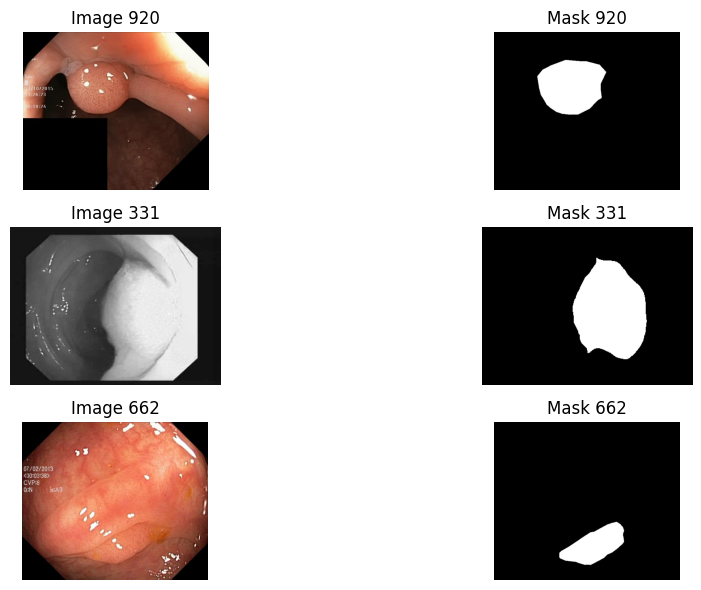

In [1]:
import os
import glob
import random
import cv2
import matplotlib.pyplot as plt

# ===== Current merged dataset paths (CONFIRMED) =====
merged_img_dir  = "/content/drive/MyDrive/colorectal/combined/images"
merged_mask_dir = "/content/drive/MyDrive/colorectal/combined/masks"

# Collect merged files
all_imgs  = sorted(glob.glob(os.path.join(merged_img_dir, "*")))
all_masks = sorted(glob.glob(os.path.join(merged_mask_dir, "*")))

print("Total images:", len(all_imgs))
print("Total masks :", len(all_masks))

# Choose 3 random samples
sample_idxs = random.sample(range(len(all_imgs)), 3)

plt.figure(figsize=(12, 6))

for i, idx in enumerate(sample_idxs):
    img  = cv2.imread(all_imgs[idx])
    mask = cv2.imread(all_masks[idx], cv2.IMREAD_GRAYSCALE)

    img  = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    mask = cv2.resize(mask, (img.shape[1], img.shape[0]))

    plt.subplot(3, 2, 2*i + 1)
    plt.imshow(img)
    plt.title(f"Image {idx}")
    plt.axis("off")

    plt.subplot(3, 2, 2*i + 2)
    plt.imshow(mask, cmap="gray")
    plt.title(f"Mask {idx}")
    plt.axis("off")

plt.tight_layout()
plt.show()


In [2]:
# STEP 6 — Robust TF dataset loader (handles JPG, PNG, TIFF)
import tensorflow as tf
import numpy as np
import cv2
import os
from sklearn.model_selection import train_test_split

IMG_SIZE = (256, 256)

# ---------- Decode Function ----------
def _py_decode_image(path, channels):
    """Reads image (supports jpg, png, tif) and converts to desired channels."""
    p = path.decode() if isinstance(path, bytes) else str(path)
    img = cv2.imread(p, cv2.IMREAD_UNCHANGED)
    if img is None:
        raise ValueError(f"Cannot read image: {p}")

    # Convert to correct number of channels
    if channels == 3:
        if len(img.shape) == 2:
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        elif img.shape[2] == 4:
            img = cv2.cvtColor(img, cv2.COLOR_BGRA2BGR)
    elif channels == 1:
        if len(img.shape) == 3:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    img = cv2.resize(img, IMG_SIZE, interpolation=cv2.INTER_NEAREST)
    img = img.astype(np.float32) / 255.0

    if channels == 1:
        img = np.expand_dims(img, axis=-1)

    return img

# ---------- Load pair ----------
def _load_pair(img_path, mask_path):
    img = tf.numpy_function(_py_decode_image, [img_path, 3], tf.float32)
    mask = tf.numpy_function(_py_decode_image, [mask_path, 1], tf.float32)
    img.set_shape((*IMG_SIZE, 3))
    mask.set_shape((*IMG_SIZE, 1))
    return img, mask

# ---------- Dataset builder ----------
def make_tf_dataset(img_paths, mask_paths, batch_size=8, shuffle=True):
    ds = tf.data.Dataset.from_tensor_slices((img_paths, mask_paths))
    ds = ds.map(_load_pair, num_parallel_calls=tf.data.AUTOTUNE)
    if shuffle:
        ds = ds.shuffle(buffer_size=100)
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

# ---------- Split data ----------
train_imgs, test_imgs, train_masks, test_masks = train_test_split(all_imgs, all_masks, test_size=0.1, random_state=42)
train_imgs, val_imgs, train_masks, val_masks = train_test_split(train_imgs, train_masks, test_size=0.1, random_state=42)

train_ds = make_tf_dataset(train_imgs, train_masks)
val_ds = make_tf_dataset(val_imgs, val_masks, shuffle=False)
test_ds = make_tf_dataset(test_imgs, test_masks, shuffle=False)

print(f"✅ Train: {len(train_imgs)} | Val: {len(val_imgs)} | Test: {len(test_imgs)}")


✅ Train: 1305 | Val: 145 | Test: 162


In [3]:
# =========================
# MULTI-TASK DATA PIPELINE
# Segmentation + Classification
# =========================

import tensorflow as tf
import numpy as np
import cv2
import os

# -------------------------
# Global parameters
# -------------------------
IMG_SIZE = (256, 256)
BATCH_SIZE = 8

# -------------------------
# 1. Classification labels
# (All images contain polyps → label = 1)
# -------------------------
train_labels = np.ones(len(train_imgs), dtype=np.float32)
val_labels   = np.ones(len(val_imgs), dtype=np.float32)
test_labels  = np.ones(len(test_imgs), dtype=np.float32)

# -------------------------
# 2. Python image decoder (TIFF / JPG / PNG SAFE)
# -------------------------
def _py_decode_image(path, channels):
    path = path.decode("utf-8")

    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    if img is None:
        raise ValueError(f"Failed to read image: {path}")

    # Image
    if channels == 3:
        if len(img.shape) == 2:
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        else:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # Mask
    else:
        if len(img.shape) == 3:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    img = cv2.resize(img, IMG_SIZE)
    img = img.astype(np.float32) / 255.0

    if channels == 1:
        img = np.expand_dims(img, axis=-1)

    return img

# -------------------------
# 3. Load image + mask + label
# -------------------------
def _load_pair_with_label(img_path, mask_path, label):
    img = tf.numpy_function(_py_decode_image, [img_path, 3], tf.float32)
    mask = tf.numpy_function(_py_decode_image, [mask_path, 1], tf.float32)

    img.set_shape((*IMG_SIZE, 3))
    mask.set_shape((*IMG_SIZE, 1))
    label = tf.cast(label, tf.float32)

    return img, {
        "seg_output": mask,
        "class_output": label
    }

# -------------------------
# 4. Dataset builder
# -------------------------
def make_multitask_dataset(img_paths, mask_paths, labels, batch_size=8, shuffle=True):
    ds = tf.data.Dataset.from_tensor_slices((img_paths, mask_paths, labels))
    ds = ds.map(_load_pair_with_label, num_parallel_calls=tf.data.AUTOTUNE)

    if shuffle:
        ds = ds.shuffle(100)

    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

# -------------------------
# 5. Create datasets
# -------------------------
train_ds = make_multitask_dataset(
    train_imgs, train_masks, train_labels,
    batch_size=BATCH_SIZE, shuffle=True
)

val_ds = make_multitask_dataset(
    val_imgs, val_masks, val_labels,
    batch_size=BATCH_SIZE, shuffle=False
)

test_ds = make_multitask_dataset(
    test_imgs, test_masks, test_labels,
    batch_size=BATCH_SIZE, shuffle=False
)

# -------------------------
# 6. Sanity check
# -------------------------
for imgs, outputs in train_ds.take(1):
    print("Image shape      :", imgs.shape)
    print("Seg output shape :", outputs["seg_output"].shape)
    print("Class output shape:", outputs["class_output"].shape)


Image shape      : (8, 256, 256, 3)
Seg output shape : (8, 256, 256, 1)
Class output shape: (8,)


In [6]:
# ============================================================
# FINAL CORRECTED MULTI-TASK MODEL
# ConvNeXt + Transformer + U-Net++ (256×256 output)
# ============================================================

import tensorflow as tf
from tensorflow.keras import layers, models

# -------------------------
# LayerNorm for CNN maps
# -------------------------
class LayerNorm2D(layers.Layer):
    def __init__(self, epsilon=1e-6):
        super().__init__()
        self.norm = layers.LayerNormalization(epsilon=epsilon)

    def call(self, x):
        return self.norm(x)

# -------------------------
# ConvNeXt block
# -------------------------
def convnext_block(x, dim):
    shortcut = x
    x = layers.DepthwiseConv2D(7, padding="same")(x)
    x = LayerNorm2D()(x)
    x = layers.Dense(4 * dim, activation="gelu")(x)
    x = layers.Dense(dim)(x)
    return layers.Add()([shortcut, x])

# -------------------------
# ConvNeXt stage
# -------------------------
def convnext_stage(x, dim, depth, downsample=True):
    if downsample:
        x = layers.Conv2D(dim, 2, strides=2)(x)
    for _ in range(depth):
        x = convnext_block(x, dim)
    return x

# -------------------------
# Transformer block
# -------------------------
def transformer_block(x, heads=4, mlp_dim=512):
    skip = x
    x = layers.LayerNormalization()(x)
    x = layers.MultiHeadAttention(
        num_heads=heads,
        key_dim=x.shape[-1]
    )(x, x)
    x = layers.Add()([x, skip])

    skip = x
    x = layers.LayerNormalization()(x)
    x = layers.Dense(mlp_dim, activation="gelu")(x)
    x = layers.Dense(skip.shape[-1])(x)
    return layers.Add()([x, skip])

# -------------------------
# Transformer bottleneck
# -------------------------
def transformer_bottleneck(x, blocks=2):
    h, w, c = x.shape[1], x.shape[2], x.shape[3]
    x = layers.Reshape((h * w, c))(x)
    for _ in range(blocks):
        x = transformer_block(x)
    return layers.Reshape((h, w, c))(x)

# -------------------------
# Decoder block
# -------------------------
def decoder_block(x, skip):
    x = layers.UpSampling2D(2, interpolation="bilinear")(x)
    x = layers.Concatenate()([x, skip])
    x = layers.Conv2D(skip.shape[-1], 3, padding="same", activation="relu")(x)
    x = layers.Conv2D(skip.shape[-1], 3, padding="same", activation="relu")(x)
    return x

# -------------------------
# BUILD MODEL
# -------------------------
def build_multitask_ctu_net(input_shape=(256, 256, 3)):
    inputs = layers.Input(input_shape)

    # ===== Encoder =====
    x = layers.Conv2D(96, 4, strides=4)(inputs)  # 64×64
    x = LayerNorm2D()(x)

    e1 = convnext_stage(x, 96, 2, downsample=False)  # 64×64
    e2 = convnext_stage(e1, 192, 2)                  # 32×32
    e3 = convnext_stage(e2, 384, 4)                  # 16×16
    e4 = convnext_stage(e3, 768, 2)                  # 8×8

    # ===== Transformer =====
    t = transformer_bottleneck(e4, blocks=2)

    # ===== Classification head =====
    cls = layers.GlobalAveragePooling2D()(t)
    cls = layers.Dense(256, activation="relu")(cls)
    class_output = layers.Dense(
        1, activation="sigmoid", name="class_output"
    )(cls)

    # ===== Decoder =====
    d3 = decoder_block(t, e3)   # 16×16
    d2 = decoder_block(d3, e2)  # 32×32
    d1 = decoder_block(d2, e1)  # 64×64

    # 🔥 FINAL UPSAMPLING TO FULL RESOLUTION 🔥
    u1 = layers.UpSampling2D(2, interpolation="bilinear")(d1)  # 128×128
    u1 = layers.Conv2D(64, 3, padding="same", activation="relu")(u1)

    u2 = layers.UpSampling2D(2, interpolation="bilinear")(u1)  # 256×256
    u2 = layers.Conv2D(32, 3, padding="same", activation="relu")(u2)

    seg_output = layers.Conv2D(
        1, 1, activation="sigmoid", name="seg_output"
    )(u2)

    return models.Model(
        inputs,
        outputs=[seg_output, class_output],
        name="MT_ConvNeXt_Transformer_UNetPP"
    )

# -------------------------
# Build model
# -------------------------
model = build_multitask_ctu_net()
model.summary()


Model: "MT_ConvNeXt_Transformer_UNetPP"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 64, 64,    │      4,704 │ input_layer_1[0]… │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_norm2d_11     │ (None, 64, 64,    │        192 │ conv2d_10[0][0]   │
│ (LayerNorm2D)       │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ depthwise_conv2d_10 │ (None, 64, 64,    │      4,800 │ layer_norm2d_11[… │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_norm2d_12     │ (None, 64, 64,    │        192 │ depthwise_conv2d… │
│ (LayerNorm2D)       │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_25 (Dense)    │ (None, 64, 64,    │     37,248 │ layer_norm2d_12[… │
│                     │ 384)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_26 (Dense)    │ (None, 64, 64,    │     36,960 │ dense_25[0][0]    │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_14 (Add)        │ (None, 64, 64,    │          0 │ layer_norm2d_11[… │
│                     │ 96)               │            │ dense_26[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ depthwise_conv2d_11 │ (None, 64, 64,    │      4,800 │ add_14[0][0]      │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_norm2d_13     │ (None, 64, 64,    │        192 │ depthwise_conv2d… │
│ (LayerNorm2D)       │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_27 (Dense)    │ (None, 64, 64,    │     37,248 │ layer_norm2d_13[… │
│                     │ 384)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_28 (Dense)    │ (None, 64, 64,    │     36,960 │ dense_27[0][0]    │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_15 (Add)        │ (None, 64, 64,    │          0 │ add_14[0][0],     │
│                     │ 96)               │            │ dense_28[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 32, 32,    │     73,920 │ add_15[0][0]      │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ depthwise_conv2d_12 │ (None, 32, 32,    │      9,600 │ conv2d_11[0][0]   │
│ (DepthwiseConv2D)   │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_norm2d_14     │ (None, 32, 32,    │        384 │ depthwise_conv2d… │
│ (LayerNorm2D)       │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_29 (Dense)    │ (None, 32, 32,    │    148,224 │ layer_norm2d_14[

 Total params: 44,371,042 (169.26 MB)

 Trainable params: 44,371,042 (169.26 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# ============================================================
# TRAINING PIPELINE
# Multi-Task ConvNeXt + Transformer + U-Net++
# ============================================================

import tensorflow as tf
import os

# ------------------------------------------------------------
# 1. Training configuration
# ------------------------------------------------------------
EPOCHS = 40
MODEL_DIR = "/content/drive/MyDrive/colorectal/models"
os.makedirs(MODEL_DIR, exist_ok=True)

# ------------------------------------------------------------
# 2. Custom metrics (important for segmentation quality)
# ------------------------------------------------------------
def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true = tf.reshape(y_true, [-1])
    y_pred = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (
        tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth
    )

def iou_coef(y_true, y_pred, smooth=1e-6):
    y_true = tf.reshape(y_true, [-1])
    y_pred = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    return (intersection + smooth) / (union + smooth)

# ------------------------------------------------------------
# 3. Re-compile model with proper metrics
# (ensures Dice & IoU are tracked)
# ------------------------------------------------------------
model.compile(
    optimizer=tf.keras.optimizers.AdamW(
        learning_rate=3e-4, weight_decay=1e-4
    ),
    loss={
        "seg_output": lambda y_true, y_pred:
            tf.keras.losses.binary_crossentropy(y_true, y_pred)
            + (1 - dice_coef(y_true, y_pred)),
        "class_output": "binary_crossentropy",
    },
    loss_weights={
        "seg_output": 1.0,
        "class_output": 0.3,
    },
    metrics={
        "seg_output": [dice_coef, iou_coef],
        "class_output": ["accuracy"],
    }
)

# ------------------------------------------------------------
# 4. Callbacks (CRITICAL for stability & best performance)
# ------------------------------------------------------------
callbacks = [

    # Save best model based on validation Dice
    tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(MODEL_DIR, "best_multitask_model.h5"),
        monitor="val_seg_output_dice_coef",
        save_best_only=True,
        mode="max",
        verbose=1
    ),

    # Reduce LR when validation Dice plateaus
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_seg_output_dice_coef",
        factor=0.5,
        patience=5,
        min_lr=1e-6,
        mode="max",
        verbose=1
    ),

    # Early stopping to prevent overfitting
    tf.keras.callbacks.EarlyStopping(
        monitor="val_seg_output_dice_coef",
        patience=10,
        mode="max",
        restore_best_weights=True,
        verbose=1
    )
]

# ------------------------------------------------------------
# 5. START TRAINING
# ------------------------------------------------------------
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks
)

# ------------------------------------------------------------
# 6. Save final model
# ------------------------------------------------------------
model.save(os.path.join(MODEL_DIR, "final_multitask_model"))


Epoch 1/40
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - class_output_accuracy: 0.9945 - class_output_loss: 0.0296 - loss: 1.2491 - seg_output_dice_coef: 0.1892 - seg_output_iou_coef: 0.1072 - seg_output_loss: 1.2402
Epoch 1: val_seg_output_dice_coef improved from -inf to 0.25832, saving model to /content/drive/MyDrive/colorectal/models/best_multitask_model.h5


164/164 ━━━━━━━━━━━━━━━━━━━━ 563s 3s/step - class_output_accuracy: 0.9945 - class_output_loss: 0.0295 - loss: 1.2485 - seg_output_dice_coef: 0.1896 - seg_output_iou_coef: 0.1075 - seg_output_loss: 1.2396 - val_class_output_accuracy: 1.0000 - val_class_output_loss: 2.5069e-31 - val_loss: 1.1194 - val_seg_output_dice_coef: 0.2583 - val_seg_output_iou_coef: 0.1492 - val_seg_output_loss: 1.1665 - learning_rate: 3.0000e-04
Epoch 2/40
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step - class_output_accuracy: 1.0000 - class_output_loss: 6.9265e-15 - loss: 1.0659 - seg_output_dice_coef: 0.2903 - seg_output_iou_coef: 0.1715 - seg_output_loss: 1.0659
Epoch 2: val_seg_output_dice_coef improved from 0.25832 to 0.34368, saving model to /content/drive/MyDrive/colorectal/models/best_multitask_model.h5


164/164 ━━━━━━━━━━━━━━━━━━━━ 57s 314ms/step - class_output_accuracy: 1.0000 - class_output_loss: 6.9051e-15 - loss: 1.0658 - seg_output_dice_coef: 0.2904 - seg_output_iou_coef: 0.1715 - seg_output_loss: 1.0658 - val_class_output_accuracy: 1.0000 - val_class_output_loss: 7.5871e-35 - val_loss: 1.0411 - val_seg_output_dice_coef: 0.3437 - val_seg_output_iou_coef: 0.2094 - val_seg_output_loss: 1.0546 - learning_rate: 3.0000e-04
Epoch 3/40
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step - class_output_accuracy: 1.0000 - class_output_loss: 1.4241e-24 - loss: 1.0285 - seg_output_dice_coef: 0.3239 - seg_output_iou_coef: 0.1952 - seg_output_loss: 1.0285
Epoch 3: val_seg_output_dice_coef did not improve from 0.34368
164/164 ━━━━━━━━━━━━━━━━━━━━ 56s 332ms/step - class_output_accuracy: 1.0000 - class_output_loss: 1.4190e-24 - loss: 1.0285 - seg_output_dice_coef: 0.3239 - seg_output_iou_coef: 0.1952 - seg_output_loss: 1.0285 - val_class_output_accuracy: 1.0000 - val_class_output_loss: 0.0000e+00 - val_l

164/164 ━━━━━━━━━━━━━━━━━━━━ 54s 325ms/step - class_output_accuracy: 1.0000 - class_output_loss: 0.0000e+00 - loss: 0.9133 - seg_output_dice_coef: 0.4058 - seg_output_iou_coef: 0.2573 - seg_output_loss: 0.9134 - val_class_output_accuracy: 1.0000 - val_class_output_loss: 0.0000e+00 - val_loss: 0.9371 - val_seg_output_dice_coef: 0.3989 - val_seg_output_iou_coef: 0.2515 - val_seg_output_loss: 0.9554 - learning_rate: 1.5000e-04
Epoch 10/40
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step - class_output_accuracy: 1.0000 - class_output_loss: 2.4368e-31 - loss: 0.9476 - seg_output_dice_coef: 0.3750 - seg_output_iou_coef: 0.2339 - seg_output_loss: 0.9476
Epoch 10: val_seg_output_dice_coef did not improve from 0.39890
164/164 ━━━━━━━━━━━━━━━━━━━━ 57s 339ms/step - class_output_accuracy: 1.0000 - class_output_loss: 2.4350e-31 - loss: 0.9475 - seg_output_dice_coef: 0.3751 - seg_output_iou_coef: 0.2340 - seg_output_loss: 0.9475 - val_class_output_accuracy: 1.0000 - val_class_output_loss: 0.0000e+00 - val

164/164 ━━━━━━━━━━━━━━━━━━━━ 57s 341ms/step - class_output_accuracy: 1.0000 - class_output_loss: 0.0000e+00 - loss: 0.9106 - seg_output_dice_coef: 0.4075 - seg_output_iou_coef: 0.2582 - seg_output_loss: 0.9106 - val_class_output_accuracy: 1.0000 - val_class_output_loss: 0.0000e+00 - val_loss: 0.8904 - val_seg_output_dice_coef: 0.4116 - val_seg_output_iou_coef: 0.2607 - val_seg_output_loss: 0.9145 - learning_rate: 1.5000e-04
Epoch 12/40
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step - class_output_accuracy: 1.0000 - class_output_loss: 0.0000e+00 - loss: 0.8999 - seg_output_dice_coef: 0.4170 - seg_output_iou_coef: 0.2660 - seg_output_loss: 0.8999
Epoch 12: val_seg_output_dice_coef did not improve from 0.41164
164/164 ━━━━━━━━━━━━━━━━━━━━ 58s 340ms/step - class_output_accuracy: 1.0000 - class_output_loss: 0.0000e+00 - loss: 0.8998 - seg_output_dice_coef: 0.4171 - seg_output_iou_coef: 0.2661 - seg_output_loss: 0.8998 - val_class_output_accuracy: 1.0000 - val_class_output_loss: 0.0000e+00 - val

164/164 ━━━━━━━━━━━━━━━━━━━━ 53s 319ms/step - class_output_accuracy: 1.0000 - class_output_loss: 0.0000e+00 - loss: 0.8156 - seg_output_dice_coef: 0.4685 - seg_output_iou_coef: 0.3102 - seg_output_loss: 0.8156 - val_class_output_accuracy: 1.0000 - val_class_output_loss: 0.0000e+00 - val_loss: 0.8513 - val_seg_output_dice_coef: 0.4329 - val_seg_output_iou_coef: 0.2796 - val_seg_output_loss: 0.9038 - learning_rate: 1.5000e-04
Epoch 14/40
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step - class_output_accuracy: 1.0000 - class_output_loss: 0.0000e+00 - loss: 0.8156 - seg_output_dice_coef: 0.4790 - seg_output_iou_coef: 0.3197 - seg_output_loss: 0.8156
Epoch 14: val_seg_output_dice_coef did not improve from 0.43291
164/164 ━━━━━━━━━━━━━━━━━━━━ 58s 342ms/step - class_output_accuracy: 1.0000 - class_output_loss: 0.0000e+00 - loss: 0.8157 - seg_output_dice_coef: 0.4790 - seg_output_iou_coef: 0.3197 - seg_output_loss: 0.8156 - val_class_output_accuracy: 1.0000 - val_class_output_loss: 0.0000e+00 - val

164/164 ━━━━━━━━━━━━━━━━━━━━ 55s 329ms/step - class_output_accuracy: 1.0000 - class_output_loss: 0.0000e+00 - loss: 0.7996 - seg_output_dice_coef: 0.4881 - seg_output_iou_coef: 0.3263 - seg_output_loss: 0.7996 - val_class_output_accuracy: 1.0000 - val_class_output_loss: 0.0000e+00 - val_loss: 0.8269 - val_seg_output_dice_coef: 0.4691 - val_seg_output_iou_coef: 0.3086 - val_seg_output_loss: 0.8561 - learning_rate: 1.5000e-04
Epoch 16/40
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step - class_output_accuracy: 1.0000 - class_output_loss: 0.0000e+00 - loss: 0.7600 - seg_output_dice_coef: 0.5132 - seg_output_iou_coef: 0.3493 - seg_output_loss: 0.7600
Epoch 16: val_seg_output_dice_coef did not improve from 0.46911
164/164 ━━━━━━━━━━━━━━━━━━━━ 58s 342ms/step - class_output_accuracy: 1.0000 - class_output_loss: 0.0000e+00 - loss: 0.7599 - seg_output_dice_coef: 0.5132 - seg_output_iou_coef: 0.3494 - seg_output_loss: 0.7600 - val_class_output_accuracy: 1.0000 - val_class_output_loss: 0.0000e+00 - val

164/164 ━━━━━━━━━━━━━━━━━━━━ 57s 341ms/step - class_output_accuracy: 1.0000 - class_output_loss: 0.0000e+00 - loss: 0.7219 - seg_output_dice_coef: 0.5385 - seg_output_iou_coef: 0.3731 - seg_output_loss: 0.7219 - val_class_output_accuracy: 1.0000 - val_class_output_loss: 0.0000e+00 - val_loss: 0.7752 - val_seg_output_dice_coef: 0.5121 - val_seg_output_iou_coef: 0.3476 - val_seg_output_loss: 0.8137 - learning_rate: 1.5000e-04
Epoch 20/40
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step - class_output_accuracy: 1.0000 - class_output_loss: 0.0000e+00 - loss: 0.6911 - seg_output_dice_coef: 0.5674 - seg_output_iou_coef: 0.4025 - seg_output_loss: 0.6911
Epoch 20: val_seg_output_dice_coef did not improve from 0.51205
164/164 ━━━━━━━━━━━━━━━━━━━━ 58s 343ms/step - class_output_accuracy: 1.0000 - class_output_loss: 0.0000e+00 - loss: 0.6911 - seg_output_dice_coef: 0.5674 - seg_output_iou_coef: 0.4025 - seg_output_loss: 0.6911 - val_class_output_accuracy: 1.0000 - val_class_output_loss: 0.0000e+00 - val

164/164 ━━━━━━━━━━━━━━━━━━━━ 60s 357ms/step - class_output_accuracy: 1.0000 - class_output_loss: 0.0000e+00 - loss: 0.6946 - seg_output_dice_coef: 0.5614 - seg_output_iou_coef: 0.3957 - seg_output_loss: 0.6946 - val_class_output_accuracy: 1.0000 - val_class_output_loss: 0.0000e+00 - val_loss: 0.7206 - val_seg_output_dice_coef: 0.5454 - val_seg_output_iou_coef: 0.3789 - val_seg_output_loss: 0.7611 - learning_rate: 1.5000e-04
Epoch 23/40
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step - class_output_accuracy: 1.0000 - class_output_loss: 0.0000e+00 - loss: 0.6858 - seg_output_dice_coef: 0.5719 - seg_output_iou_coef: 0.4064 - seg_output_loss: 0.6858
Epoch 23: val_seg_output_dice_coef improved from 0.54540 to 0.55091, saving model to /content/drive/MyDrive/colorectal/models/best_multitask_model.h5


164/164 ━━━━━━━━━━━━━━━━━━━━ 66s 396ms/step - class_output_accuracy: 1.0000 - class_output_loss: 0.0000e+00 - loss: 0.6856 - seg_output_dice_coef: 0.5720 - seg_output_iou_coef: 0.4064 - seg_output_loss: 0.6856 - val_class_output_accuracy: 1.0000 - val_class_output_loss: 0.0000e+00 - val_loss: 0.7029 - val_seg_output_dice_coef: 0.5509 - val_seg_output_iou_coef: 0.3904 - val_seg_output_loss: 0.7856 - learning_rate: 1.5000e-04
Epoch 24/40
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step - class_output_accuracy: 1.0000 - class_output_loss: 0.0000e+00 - loss: 0.6113 - seg_output_dice_coef: 0.6173 - seg_output_iou_coef: 0.4535 - seg_output_loss: 0.6113
Epoch 24: val_seg_output_dice_coef did not improve from 0.55091
164/164 ━━━━━━━━━━━━━━━━━━━━ 57s 337ms/step - class_output_accuracy: 1.0000 - class_output_loss: 0.0000e+00 - loss: 0.6113 - seg_output_dice_coef: 0.6173 - seg_output_iou_coef: 0.4535 - seg_output_loss: 0.6113 - val_class_output_accuracy: 1.0000 - val_class_output_loss: 0.0000e+00 - val

164/164 ━━━━━━━━━━━━━━━━━━━━ 59s 354ms/step - class_output_accuracy: 1.0000 - class_output_loss: 0.0000e+00 - loss: 0.6003 - seg_output_dice_coef: 0.6280 - seg_output_iou_coef: 0.4655 - seg_output_loss: 0.6002 - val_class_output_accuracy: 1.0000 - val_class_output_loss: 0.0000e+00 - val_loss: 0.6959 - val_seg_output_dice_coef: 0.5732 - val_seg_output_iou_coef: 0.4070 - val_seg_output_loss: 0.7359 - learning_rate: 1.5000e-04
Epoch 26/40
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step - class_output_accuracy: 1.0000 - class_output_loss: 0.0000e+00 - loss: 0.6468 - seg_output_dice_coef: 0.5982 - seg_output_iou_coef: 0.4346 - seg_output_loss: 0.6468
Epoch 26: val_seg_output_dice_coef did not improve from 0.57319
164/164 ━━━━━━━━━━━━━━━━━━━━ 57s 339ms/step - class_output_accuracy: 1.0000 - class_output_loss: 0.0000e+00 - loss: 0.6466 - seg_output_dice_coef: 0.5982 - seg_output_iou_coef: 0.4347 - seg_output_loss: 0.6466 - val_class_output_accuracy: 1.0000 - val_class_output_loss: 0.0000e+00 - val

164/164 ━━━━━━━━━━━━━━━━━━━━ 63s 377ms/step - class_output_accuracy: 1.0000 - class_output_loss: 0.0000e+00 - loss: 0.6080 - seg_output_dice_coef: 0.6217 - seg_output_iou_coef: 0.4582 - seg_output_loss: 0.6080 - val_class_output_accuracy: 1.0000 - val_class_output_loss: 0.0000e+00 - val_loss: 0.6910 - val_seg_output_dice_coef: 0.5772 - val_seg_output_iou_coef: 0.4167 - val_seg_output_loss: 0.7682 - learning_rate: 1.5000e-04
Epoch 28/40
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step - class_output_accuracy: 1.0000 - class_output_loss: 0.0000e+00 - loss: 0.5550 - seg_output_dice_coef: 0.6574 - seg_output_iou_coef: 0.4962 - seg_output_loss: 0.5550
Epoch 28: val_seg_output_dice_coef improved from 0.57721 to 0.59535, saving model to /content/drive/MyDrive/colorectal/models/best_multitask_model.h5


164/164 ━━━━━━━━━━━━━━━━━━━━ 68s 405ms/step - class_output_accuracy: 1.0000 - class_output_loss: 0.0000e+00 - loss: 0.5549 - seg_output_dice_coef: 0.6575 - seg_output_iou_coef: 0.4962 - seg_output_loss: 0.5550 - val_class_output_accuracy: 1.0000 - val_class_output_loss: 0.0000e+00 - val_loss: 0.6592 - val_seg_output_dice_coef: 0.5953 - val_seg_output_iou_coef: 0.4309 - val_seg_output_loss: 0.7110 - learning_rate: 1.5000e-04
Epoch 29/40
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step - class_output_accuracy: 1.0000 - class_output_loss: 0.0000e+00 - loss: 0.5446 - seg_output_dice_coef: 0.6632 - seg_output_iou_coef: 0.5039 - seg_output_loss: 0.5446
Epoch 29: val_seg_output_dice_coef did not improve from 0.59535
164/164 ━━━━━━━━━━━━━━━━━━━━ 56s 332ms/step - class_output_accuracy: 1.0000 - class_output_loss: 0.0000e+00 - loss: 0.5447 - seg_output_dice_coef: 0.6632 - seg_output_iou_coef: 0.5038 - seg_output_loss: 0.5447 - val_class_output_accuracy: 1.0000 - val_class_output_loss: 0.0000e+00 - val

164/164 ━━━━━━━━━━━━━━━━━━━━ 58s 347ms/step - class_output_accuracy: 1.0000 - class_output_loss: 0.0000e+00 - loss: 0.4536 - seg_output_dice_coef: 0.7211 - seg_output_iou_coef: 0.5714 - seg_output_loss: 0.4536 - val_class_output_accuracy: 1.0000 - val_class_output_loss: 0.0000e+00 - val_loss: 0.6266 - val_seg_output_dice_coef: 0.6095 - val_seg_output_iou_coef: 0.4495 - val_seg_output_loss: 0.6952 - learning_rate: 7.5000e-05
Epoch 35/40
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step - class_output_accuracy: 1.0000 - class_output_loss: 0.0000e+00 - loss: 0.4088 - seg_output_dice_coef: 0.7525 - seg_output_iou_coef: 0.6076 - seg_output_loss: 0.4088
Epoch 35: val_seg_output_dice_coef improved from 0.60952 to 0.62081, saving model to /content/drive/MyDrive/colorectal/models/best_multitask_model.h5


164/164 ━━━━━━━━━━━━━━━━━━━━ 79s 473ms/step - class_output_accuracy: 1.0000 - class_output_loss: 0.0000e+00 - loss: 0.4087 - seg_output_dice_coef: 0.7524 - seg_output_iou_coef: 0.6076 - seg_output_loss: 0.4088 - val_class_output_accuracy: 1.0000 - val_class_output_loss: 0.0000e+00 - val_loss: 0.6074 - val_seg_output_dice_coef: 0.6208 - val_seg_output_iou_coef: 0.4641 - val_seg_output_loss: 0.6897 - learning_rate: 7.5000e-05
Epoch 36/40
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step - class_output_accuracy: 1.0000 - class_output_loss: 0.0000e+00 - loss: 0.3800 - seg_output_dice_coef: 0.7701 - seg_output_iou_coef: 0.6314 - seg_output_loss: 0.3801
Epoch 36: val_seg_output_dice_coef improved from 0.62081 to 0.62677, saving model to /content/drive/MyDrive/colorectal/models/best_multitask_model.h5


164/164 ━━━━━━━━━━━━━━━━━━━━ 74s 439ms/step - class_output_accuracy: 1.0000 - class_output_loss: 0.0000e+00 - loss: 0.3800 - seg_output_dice_coef: 0.7701 - seg_output_iou_coef: 0.6314 - seg_output_loss: 0.3801 - val_class_output_accuracy: 1.0000 - val_class_output_loss: 0.0000e+00 - val_loss: 0.6186 - val_seg_output_dice_coef: 0.6268 - val_seg_output_iou_coef: 0.4712 - val_seg_output_loss: 0.7074 - learning_rate: 7.5000e-05
Epoch 37/40
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step - class_output_accuracy: 1.0000 - class_output_loss: 0.0000e+00 - loss: 0.3949 - seg_output_dice_coef: 0.7614 - seg_output_iou_coef: 0.6210 - seg_output_loss: 0.3950
Epoch 37: val_seg_output_dice_coef did not improve from 0.62677
164/164 ━━━━━━━━━━━━━━━━━━━━ 57s 337ms/step - class_output_accuracy: 1.0000 - class_output_loss: 0.0000e+00 - loss: 0.3950 - seg_output_dice_coef: 0.7613 - seg_output_iou_coef: 0.6209 - seg_output_loss: 0.3950 - val_class_output_accuracy: 1.0000 - val_class_output_loss: 0.0000e+00 - val

ValueError: Invalid filepath extension for saving. Please add either a `.keras` extension for the native Keras format (recommended) or a `.h5` extension. Use `model.export(filepath)` if you want to export a SavedModel for use with TFLite/TFServing/etc. Received: filepath=/content/drive/MyDrive/colorectal/models/final_multitask_model.

In [8]:
model.save("/content/drive/MyDrive/colorectal/models/best_multitask_model.keras")


/usr/local/lib/python3.12/dist-packages/keras/src/saving/serialization_lib.py:390: UserWarning: The object being serialized includes a `lambda`. This is unsafe. In order to reload the object, you will have to pass `safe_mode=False` to the loading function. Please avoid using `lambda` in the future, and use named Python functions instead. This is the `lambda` being serialized:         "seg_output": lambda y_true, y_pred:

  return {key: serialize_keras_object(value) for key, value in obj.items()}


In [9]:
# ============================================================
# TEST SET EVALUATION
# ============================================================

test_results = model.evaluate(test_ds, verbose=1)

for name, value in zip(model.metrics_names, test_results):
    print(f"{name}: {value:.4f}")


21/21 ━━━━━━━━━━━━━━━━━━━━ 63s 3s/step - class_output_accuracy: 1.0000 - class_output_loss: 0.0000e+00 - loss: 0.7101 - seg_output_dice_coef: 0.6222 - seg_output_iou_coef: 0.4674 - seg_output_loss: 0.7113
loss: 0.6366
compile_metrics: 0.6500
seg_output_loss: 0.0000
class_output_loss: 1.0000


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


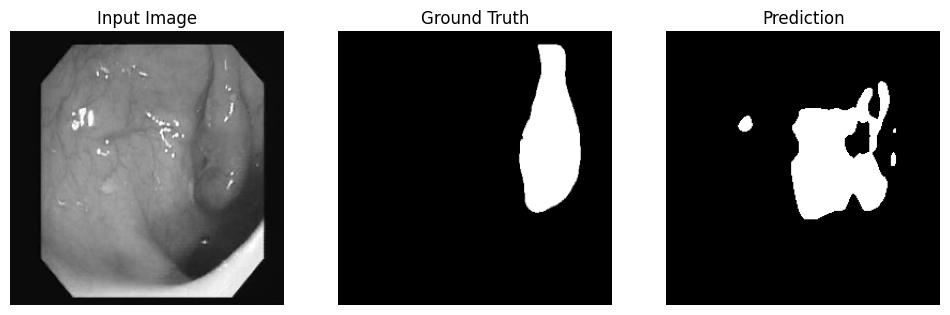

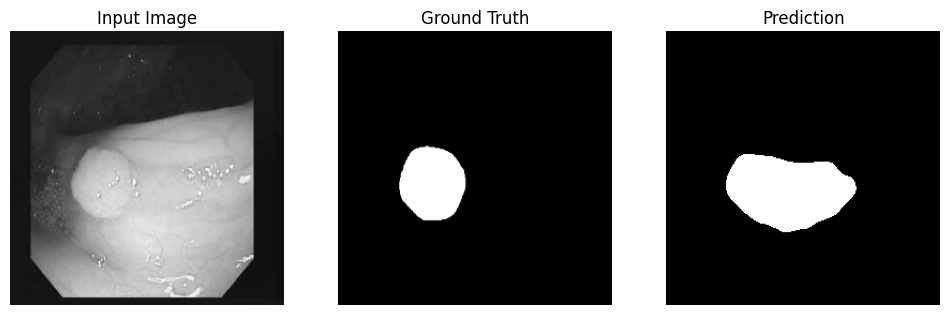

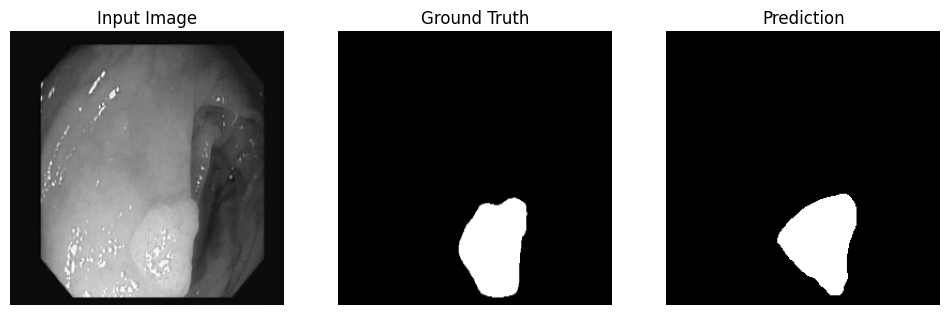

In [12]:
# ============================================================
# VISUALIZE SEGMENTATION RESULTS
# ============================================================

import matplotlib.pyplot as plt
import numpy as np

def visualize_predictions(model, dataset, num_samples=3):
    for images, outputs in dataset.take(1):
        preds, _ = model.predict(images)

        for i in range(num_samples):
            img  = images[i].numpy()
            gt   = outputs["seg_output"][i].numpy().squeeze()
            pred = preds[i].squeeze()

            plt.figure(figsize=(12, 4))

            plt.subplot(1, 3, 1)
            plt.imshow(img)
            plt.title("Input Image")
            plt.axis("off")

            plt.subplot(1, 3, 2)
            plt.imshow(gt, cmap="gray")
            plt.title("Ground Truth")
            plt.axis("off")

            plt.subplot(1, 3, 3)
            plt.imshow(pred > 0.5, cmap="gray")
            plt.title("Prediction")
            plt.axis("off")

            plt.show()

# Run visualization
visualize_predictions(model, test_ds)


In [13]:
# ============================================================
# FINAL REFINEMENT CELL
# Boundary Loss + Fine-Tuning + Visualization
# ============================================================

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy.ndimage import label

# ------------------------------------------------------------
# 1. Metrics (same as before)
# ------------------------------------------------------------
def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true = tf.reshape(y_true, [-1])
    y_pred = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (
        tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth
    )

def iou_coef(y_true, y_pred, smooth=1e-6):
    y_true = tf.reshape(y_true, [-1])
    y_pred = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    return (intersection + smooth) / (union + smooth)

# ------------------------------------------------------------
# 2. Boundary Loss (KEY FIX)
# ------------------------------------------------------------
def boundary_loss(y_true, y_pred):
    sobel_true = tf.image.sobel_edges(y_true)
    sobel_pred = tf.image.sobel_edges(y_pred)
    return tf.reduce_mean(tf.abs(sobel_true - sobel_pred))

# ------------------------------------------------------------
# 3. Re-compile model with boundary-aware loss
# ------------------------------------------------------------
model.compile(
    optimizer=tf.keras.optimizers.AdamW(
        learning_rate=1e-4, weight_decay=1e-4
    ),
    loss={
        "seg_output": lambda y_true, y_pred:
            tf.keras.losses.binary_crossentropy(y_true, y_pred)
            + (1 - dice_coef(y_true, y_pred))
            + 0.3 * boundary_loss(y_true, y_pred),
        "class_output": "binary_crossentropy",
    },
    loss_weights={
        "seg_output": 1.0,
        "class_output": 0.3,
    },
    metrics={
        "seg_output": [dice_coef, iou_coef],
        "class_output": ["accuracy"],
    }
)

# ------------------------------------------------------------
# 4. Fine-tune (DO NOT retrain from scratch)
# ------------------------------------------------------------
print("🔧 Fine-tuning with boundary loss...")
history_ft = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    callbacks=callbacks
)

# ------------------------------------------------------------
# 5. Post-processing: Keep largest connected component
# ------------------------------------------------------------
def keep_largest_component(mask):
    labeled, num = label(mask)
    if num == 0:
        return mask
    sizes = np.bincount(labeled.ravel())
    sizes[0] = 0
    largest = sizes.argmax()
    return (labeled == largest).astype(np.uint8)

# ------------------------------------------------------------
# 6. Visualization after refinement
# ------------------------------------------------------------
def visualize_refined_predictions(model, dataset, num_samples=3):
    for images, outputs in dataset.take(1):
        preds, _ = model.predict(images)

        for i in range(num_samples):
            img  = images[i].numpy()
            gt   = outputs["seg_output"][i].numpy().squeeze()
            pred = preds[i].squeeze()

            # Threshold + post-process
            pred_bin = (pred > 0.5).astype(np.uint8)
            pred_bin = keep_largest_component(pred_bin)

            plt.figure(figsize=(12, 4))

            plt.subplot(1, 3, 1)
            plt.imshow(img)
            plt.title("Input Image")
            plt.axis("off")

            plt.subplot(1, 3, 2)
            plt.imshow(gt, cmap="gray")
            plt.title("Ground Truth")
            plt.axis("off")

            plt.subplot(1, 3, 3)
            plt.imsho


🔧 Fine-tuning with boundary loss...
Epoch 1/15
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step - class_output_accuracy: 1.0000 - class_output_loss: 0.0000e+00 - loss: 0.3830 - seg_output_dice_coef: 0.7774 - seg_output_iou_coef: 0.6416 - seg_output_loss: 0.3831
Epoch 1: val_seg_output_dice_coef did not improve from 0.62677
164/164 ━━━━━━━━━━━━━━━━━━━━ 117s 416ms/step - class_output_accuracy: 1.0000 - class_output_loss: 0.0000e+00 - loss: 0.3830 - seg_output_dice_coef: 0.7774 - seg_output_iou_coef: 0.6416 - seg_output_loss: 0.3831 - val_class_output_accuracy: 1.0000 - val_class_output_loss: 0.0000e+00 - val_loss: 0.6587 - val_seg_output_dice_coef: 0.6179 - val_seg_output_iou_coef: 0.4559 - val_seg_output_loss: 0.7262 - learning_rate: 1.0000e-04
Epoch 2/15
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step - class_output_accuracy: 1.0000 - class_output_loss: 0.0000e+00 - loss: 0.3450 - seg_output_dice_coef: 0.7983 - seg_output_iou_coef: 0.6693 - seg_output_loss: 0.3450
Epoch 2: val_seg_output_dice_coe

164/164 ━━━━━━━━━━━━━━━━━━━━ 70s 419ms/step - class_output_accuracy: 1.0000 - class_output_loss: 0.0000e+00 - loss: 0.3382 - seg_output_dice_coef: 0.8096 - seg_output_iou_coef: 0.6845 - seg_output_loss: 0.3382 - val_class_output_accuracy: 1.0000 - val_class_output_loss: 0.0000e+00 - val_loss: 0.6365 - val_seg_output_dice_coef: 0.6352 - val_seg_output_iou_coef: 0.4802 - val_seg_output_loss: 0.7345 - learning_rate: 1.0000e-04
Epoch 4/15
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step - class_output_accuracy: 1.0000 - class_output_loss: 0.0000e+00 - loss: 0.3066 - seg_output_dice_coef: 0.8261 - seg_output_iou_coef: 0.7070 - seg_output_loss: 0.3066
Epoch 4: val_seg_output_dice_coef did not improve from 0.63523
164/164 ━━━━━━━━━━━━━━━━━━━━ 58s 341ms/step - class_output_accuracy: 1.0000 - class_output_loss: 0.0000e+00 - loss: 0.3065 - seg_output_dice_coef: 0.8261 - seg_output_iou_coef: 0.7070 - seg_output_loss: 0.3065 - val_class_output_accuracy: 1.0000 - val_class_output_loss: 0.0000e+00 - val_l

164/164 ━━━━━━━━━━━━━━━━━━━━ 62s 374ms/step - class_output_accuracy: 1.0000 - class_output_loss: 0.0000e+00 - loss: 0.2726 - seg_output_dice_coef: 0.8477 - seg_output_iou_coef: 0.7385 - seg_output_loss: 0.2726 - val_class_output_accuracy: 1.0000 - val_class_output_loss: 0.0000e+00 - val_loss: 0.6429 - val_seg_output_dice_coef: 0.6404 - val_seg_output_iou_coef: 0.4834 - val_seg_output_loss: 0.7283 - learning_rate: 1.0000e-04
Epoch 6/15
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step - class_output_accuracy: 1.0000 - class_output_loss: 0.0000e+00 - loss: 0.2718 - seg_output_dice_coef: 0.8475 - seg_output_iou_coef: 0.7383 - seg_output_loss: 0.2718
Epoch 6: val_seg_output_dice_coef did not improve from 0.64040
164/164 ━━━━━━━━━━━━━━━━━━━━ 57s 340ms/step - class_output_accuracy: 1.0000 - class_output_loss: 0.0000e+00 - loss: 0.2718 - seg_output_dice_coef: 0.8475 - seg_output_iou_coef: 0.7383 - seg_output_loss: 0.2718 - val_class_output_accuracy: 1.0000 - val_class_output_loss: 0.0000e+00 - val_l

164/164 ━━━━━━━━━━━━━━━━━━━━ 58s 345ms/step - class_output_accuracy: 1.0000 - class_output_loss: 0.0000e+00 - loss: 0.2056 - seg_output_dice_coef: 0.8857 - seg_output_iou_coef: 0.7971 - seg_output_loss: 0.2056 - val_class_output_accuracy: 1.0000 - val_class_output_loss: 0.0000e+00 - val_loss: 0.6757 - val_seg_output_dice_coef: 0.6520 - val_seg_output_iou_coef: 0.5000 - val_seg_output_loss: 0.7817 - learning_rate: 1.0000e-04
Epoch 10/15
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step - class_output_accuracy: 1.0000 - class_output_loss: 0.0000e+00 - loss: 0.1845 - seg_output_dice_coef: 0.8992 - seg_output_iou_coef: 0.8181 - seg_output_loss: 0.1845
Epoch 10: val_seg_output_dice_coef did not improve from 0.65201
164/164 ━━━━━━━━━━━━━━━━━━━━ 58s 345ms/step - class_output_accuracy: 1.0000 - class_output_loss: 0.0000e+00 - loss: 0.1846 - seg_output_dice_coef: 0.8992 - seg_output_iou_coef: 0.8180 - seg_output_loss: 0.1846 - val_class_output_accuracy: 1.0000 - val_class_output_loss: 0.0000e+00 - val

164/164 ━━━━━━━━━━━━━━━━━━━━ 62s 374ms/step - class_output_accuracy: 1.0000 - class_output_loss: 0.0000e+00 - loss: 0.1629 - seg_output_dice_coef: 0.9102 - seg_output_iou_coef: 0.8365 - seg_output_loss: 0.1629 - val_class_output_accuracy: 1.0000 - val_class_output_loss: 0.0000e+00 - val_loss: 0.6958 - val_seg_output_dice_coef: 0.6528 - val_seg_output_iou_coef: 0.4996 - val_seg_output_loss: 0.8188 - learning_rate: 1.0000e-04
Epoch 14/15
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step - class_output_accuracy: 1.0000 - class_output_loss: 0.0000e+00 - loss: 0.1381 - seg_output_dice_coef: 0.9247 - seg_output_iou_coef: 0.8607 - seg_output_loss: 0.1381
Epoch 14: val_seg_output_dice_coef improved from 0.65278 to 0.65853, saving model to /content/drive/MyDrive/colorectal/models/best_multitask_model.h5


164/164 ━━━━━━━━━━━━━━━━━━━━ 72s 431ms/step - class_output_accuracy: 1.0000 - class_output_loss: 0.0000e+00 - loss: 0.1381 - seg_output_dice_coef: 0.9247 - seg_output_iou_coef: 0.8607 - seg_output_loss: 0.1380 - val_class_output_accuracy: 1.0000 - val_class_output_loss: 0.0000e+00 - val_loss: 0.7180 - val_seg_output_dice_coef: 0.6585 - val_seg_output_iou_coef: 0.5101 - val_seg_output_loss: 0.8714 - learning_rate: 1.0000e-04
Epoch 15/15
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step - class_output_accuracy: 1.0000 - class_output_loss: 0.0000e+00 - loss: 0.1345 - seg_output_dice_coef: 0.9274 - seg_output_iou_coef: 0.8655 - seg_output_loss: 0.1345
Epoch 15: val_seg_output_dice_coef did not improve from 0.65853
164/164 ━━━━━━━━━━━━━━━━━━━━ 57s 340ms/step - class_output_accuracy: 1.0000 - class_output_loss: 0.0000e+00 - loss: 0.1345 - seg_output_dice_coef: 0.9273 - seg_output_iou_coef: 0.8654 - seg_output_loss: 0.1345 - val_class_output_accuracy: 1.0000 - val_class_output_loss: 0.0000e+00 - val

In [14]:
model.save(
    "/content/drive/MyDrive/colorectal/models/final_multitask_boundary_model.keras"
)


In [15]:
test_results = model.evaluate(test_ds, verbose=1)

for name, value in zip(model.metrics_names, test_results):
    print(f"{name}: {value:.4f}")


21/21 ━━━━━━━━━━━━━━━━━━━━ 10s 467ms/step - class_output_accuracy: 1.0000 - class_output_loss: 0.0000e+00 - loss: 0.8574 - seg_output_dice_coef: 0.6486 - seg_output_iou_coef: 0.4976 - seg_output_loss: 0.8588
loss: 0.7638
compile_metrics: 0.7790
seg_output_loss: 0.0000
class_output_loss: 1.0000


In [16]:
import numpy as np

# Take one batch from test set
for images, outputs in test_ds.take(1):
    seg_preds, class_preds = model.predict(images)

print("Segmentation output shape:", seg_preds.shape)
print("Classification output shape:", class_preds.shape)

# Print classification probabilities
for i in range(min(5, len(class_preds))):
    print(f"Image {i} → Polyp probability: {class_preds[i][0]:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
Segmentation output shape: (8, 256, 256, 1)
Classification output shape: (8, 1)
Image 0 → Polyp probability: 1.0000
Image 1 → Polyp probability: 1.0000
Image 2 → Polyp probability: 1.0000
Image 3 → Polyp probability: 1.0000
Image 4 → Polyp probability: 1.0000


In [17]:
from scipy.ndimage import label

def keep_largest_component(mask):
    labeled, num = label(mask)
    if num == 0:
        return mask
    sizes = np.bincount(labeled.ravel())
    sizes[0] = 0
    largest = sizes.argmax()
    return (labeled == largest).astype(np.uint8)

final_masks = []

for i in range(len(seg_preds)):
    mask = (seg_preds[i] > 0.5).astype(np.uint8)
    mask = keep_largest_component(mask.squeeze())
    final_masks.append(mask)

final_masks = np.array(final_masks)
print("Final masks ready:", final_masks.shape)


Final masks ready: (8, 256, 256)


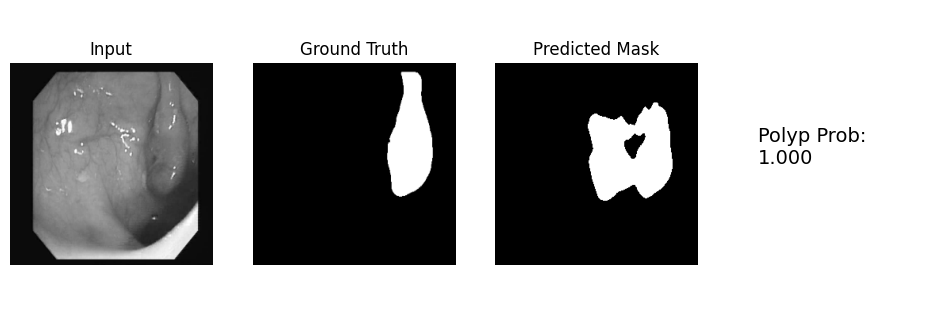

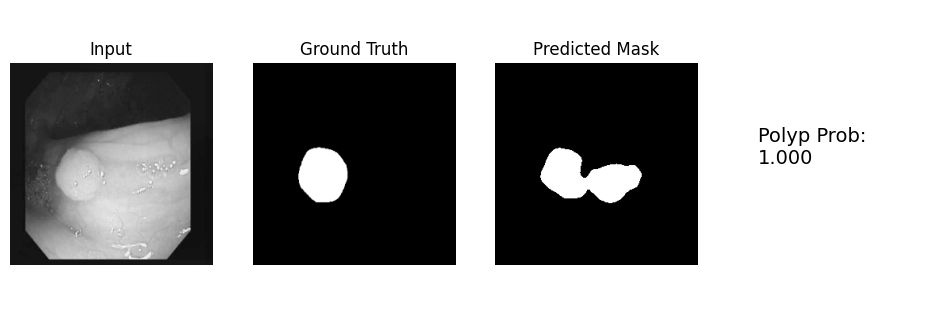

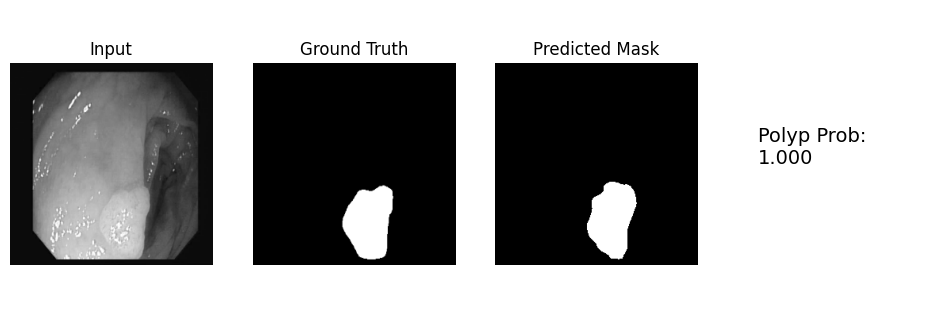

In [18]:
import matplotlib.pyplot as plt

def show_outputs(images, gt_masks, pred_masks, class_preds, n=3):
    for i in range(n):
        plt.figure(figsize=(12,4))

        plt.subplot(1,4,1)
        plt.imshow(images[i])
        plt.title("Input")
        plt.axis("off")

        plt.subplot(1,4,2)
        plt.imshow(gt_masks[i].squeeze(), cmap="gray")
        plt.title("Ground Truth")
        plt.axis("off")

        plt.subplot(1,4,3)
        plt.imshow(pred_masks[i], cmap="gray")
        plt.title("Predicted Mask")
        plt.axis("off")

        plt.subplot(1,4,4)
        plt.text(0.1, 0.5, f"Polyp Prob:\n{class_preds[i][0]:.3f}",
                 fontsize=14)
        plt.axis("off")

        plt.show()

# Run visualization
show_outputs(
    images.numpy(),
    outputs["seg_output"].numpy(),
    final_masks,
    class_preds,
    n=3
)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


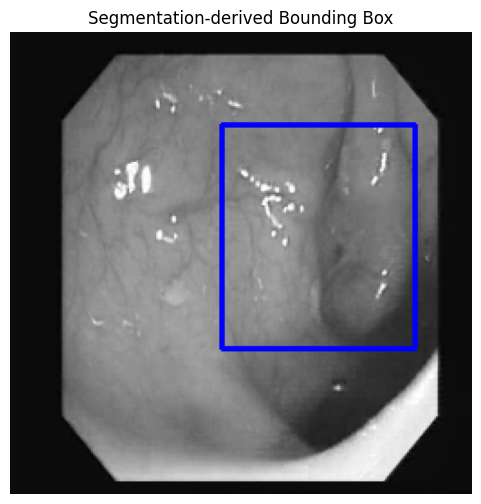

In [20]:
import cv2

def visualize_with_bbox(model, dataset):
    for images, outputs in dataset.take(1):
        seg_preds, _ = model.predict(images)

        img = images[0].numpy()
        mask = (seg_preds[0] > 0.5).astype(np.uint8).squeeze()
        mask = keep_largest_component(mask)

        contours, _ = cv2.findContours(
            (mask*255).astype(np.uint8),
            cv2.RETR_EXTERNAL,
            cv2.CHAIN_APPROX_SIMPLE
        )

        img_draw = (img * 255).astype(np.uint8)

        for cnt in contours:
            x, y, w, h = cv2.boundingRect(cnt)
            cv2.rectangle(img_draw, (x,y), (x+w,y+h), (0,0,255), 2)

        plt.figure(figsize=(6,6))
        plt.imshow(img_draw)
        plt.title("Segmentation-derived Bounding Box")
        plt.axis("off")
        plt.show()

visualize_with_bbox(model, test_ds)


In [24]:
# ============================================================
# FINAL TEST DICE & IOU (MANUAL, RELIABLE)
# ============================================================

import tensorflow as tf
import numpy as np

def dice_coef_np(y_true, y_pred, smooth=1e-6):
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    intersection = np.sum(y_true * y_pred)
    return (2. * intersection + smooth) / (
        np.sum(y_true) + np.sum(y_pred) + smooth
    )

def iou_coef_np(y_true, y_pred, smooth=1e-6):
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred) - intersection
    return (intersection + smooth) / (union + smooth)

dice_scores = []
iou_scores  = []

for images, outputs in test_ds:
    seg_preds, _ = model.predict(images, verbose=0)

    y_true = outputs["seg_output"].numpy()
    y_pred = (seg_preds > 0.5).astype(np.float32)

    for i in range(len(y_true)):
        dice_scores.append(dice_coef_np(y_true[i], y_pred[i]))
        iou_scores.append(iou_coef_np(y_true[i], y_pred[i]))

print("FINAL TEST RESULTS")
print("------------------")
print(f"Test Dice Coefficient : {np.mean(dice_scores):.4f}")
print(f"Test IoU              : {np.mean(iou_scores):.4f}")


FINAL TEST RESULTS
------------------
Test Dice Coefficient : 0.6217
Test IoU              : 0.5219


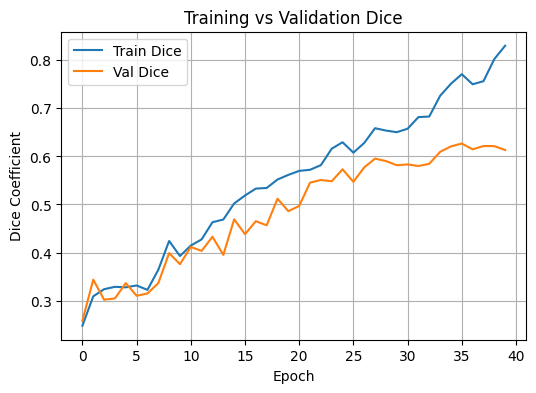

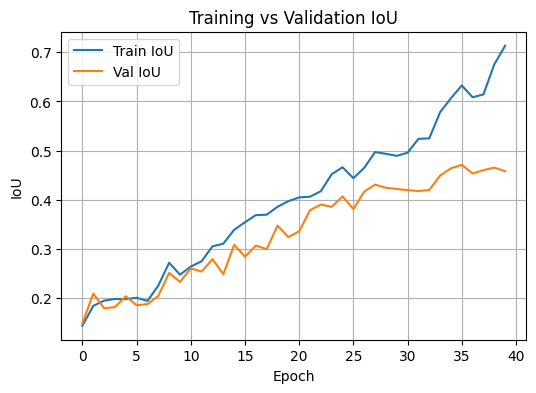

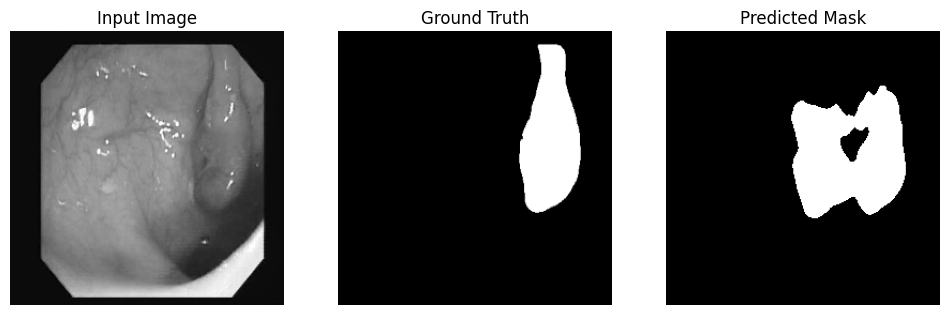

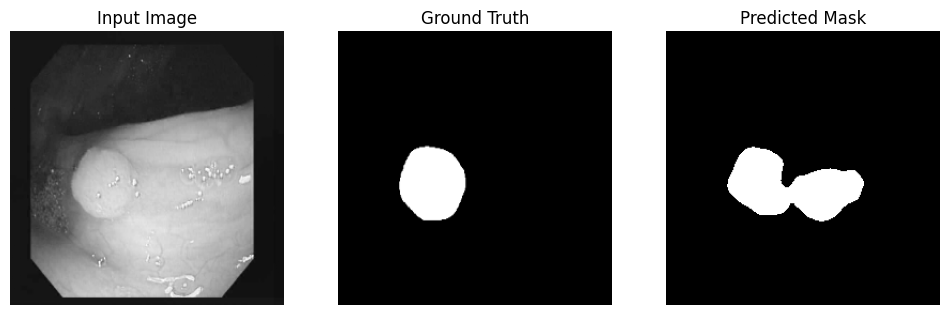

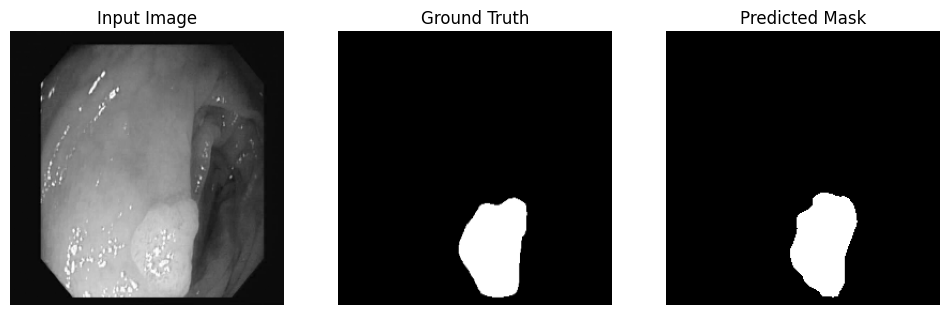

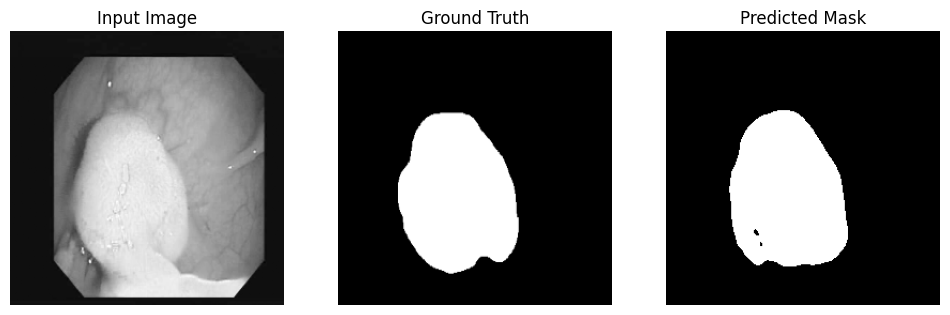

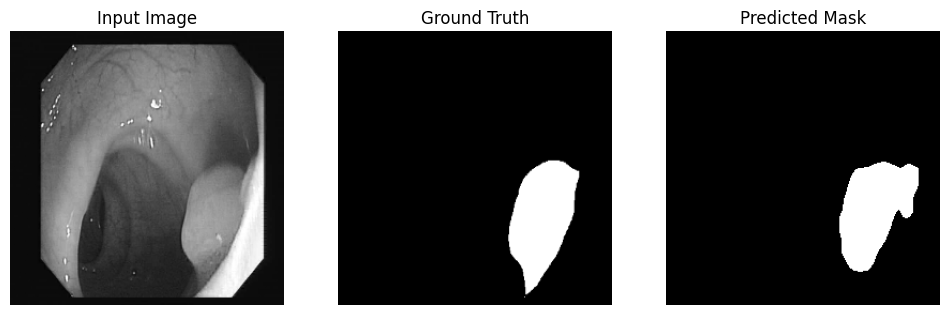

In [25]:
# ============================================================
# FINAL REQUIRED PLOTS & VISUALIZATIONS (SINGLE CELL)
# ============================================================

import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import label

# ------------------------------------------------------------
# 1. PLOT TRAINING vs VALIDATION DICE CURVE
# ------------------------------------------------------------
plt.figure(figsize=(6,4))
plt.plot(history.history['seg_output_dice_coef'], label='Train Dice')
plt.plot(history.history['val_seg_output_dice_coef'], label='Val Dice')
plt.xlabel("Epoch")
plt.ylabel("Dice Coefficient")
plt.title("Training vs Validation Dice")
plt.legend()
plt.grid(True)
plt.show()

# ------------------------------------------------------------
# 2. OPTIONAL: PLOT IOU CURVE (only if available)
# ------------------------------------------------------------
if 'seg_output_iou_coef' in history.history:
    plt.figure(figsize=(6,4))
    plt.plot(history.history['seg_output_iou_coef'], label='Train IoU')
    plt.plot(history.history['val_seg_output_iou_coef'], label='Val IoU')
    plt.xlabel("Epoch")
    plt.ylabel("IoU")
    plt.title("Training vs Validation IoU")
    plt.legend()
    plt.grid(True)
    plt.show()

# ------------------------------------------------------------
# 3. HELPER: KEEP LARGEST CONNECTED COMPONENT
# ------------------------------------------------------------
def keep_largest_component(mask):
    labeled, num = label(mask)
    if num == 0:
        return mask
    sizes = np.bincount(labeled.ravel())
    sizes[0] = 0
    return (labeled == sizes.argmax()).astype(np.uint8)

# ------------------------------------------------------------
# 4. FINAL QUALITATIVE VISUALIZATION (REPORT-READY)
# ------------------------------------------------------------
def show_final_results(model, dataset, num_samples=5):
    for images, outputs in dataset.take(1):
        seg_preds, _ = model.predict(images, verbose=0)

        for i in range(num_samples):
            img = images[i].numpy()
            gt  = outputs["seg_output"][i].numpy().squeeze()

            pred = (seg_preds[i] > 0.5).astype(np.uint8).squeeze()
            pred = keep_largest_component(pred)

            plt.figure(figsize=(12,4))

            plt.subplot(1,3,1)
            plt.imshow(img)
            plt.title("Input Image")
            plt.axis("off")

            plt.subplot(1,3,2)
            plt.imshow(gt, cmap="gray")
            plt.title("Ground Truth")
            plt.axis("off")

            plt.subplot(1,3,3)
            plt.imshow(pred, cmap="gray")
            plt.title("Predicted Mask")
            plt.axis("off")

            plt.show()

# Run qualitative visualization on TEST set
show_final_results(model, test_ds, num_samples=5)
